Text Classification with Scikit-Learn

Import Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#% matplotlib inline

In [2]:
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('agreement-sentence-agreement-DFE.csv', header=0, encoding = 'unicode_escape')


In [4]:
df_train.head()

,_unit_id,_unit_state,_trusted_judgments,_last_judgment_at,truth_response,truth_response:confidence,hypothesis,premise,truth_response_gold
0,679986253,finalized,5,2/22/15 0:32,yes,1.0000,Woman pushing a bicycle.,A woman in summer attire is walking with her b...,NaN
1,679986254,finalized,5,2/22/15 0:50,yes,1.0000,Woman pushing a bicycle.,"A girl in a white shirt, walking beside her bike.",NaN
2,679986255,finalized,5,2/22/15 1:47,yes,1.0000,Woman pushing a bicycle.,A woman walking a bike down a busy sidewalk.,NaN
3,679986256,finalized,5,2/22/15 1:13,no,0.6121,Woman pushing a bicycle.,A woman carrying her bike through a crowd.,NaN
4,679986257,finalized,5,2/22/15 0:46,yes,0.5831,A man sitting on an animal.,A boy rides a horse down a dusty country road.,NaN


We take only two columns - truth_response and premise as input and output
Input: premise.
Output: truth_response

In [5]:
from io import StringIO

col = ['truth_response', 'premise']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['premise'])]
df_train.columns = ['truth_response', 'premise']

df_train['category_id'] = df_train['truth_response'].factorize()[0]

category_id_df_train = df_train[['truth_response', 'category_id']].drop_duplicates().sort_values('category_id')

category_to_id = dict(category_id_df_train.values)

id_to_category = dict(category_id_df_train[['category_id', 'truth_response']].values)

df_train.head()

,truth_response,premise,category_id
0,yes,A woman in summer attire is walking with her b...,0
1,yes,"A girl in a white shirt, walking beside her bike.",0
2,yes,A woman walking a bike down a busy sidewalk.,0
3,no,A woman carrying her bike through a crowd.,1
4,yes,A boy rides a horse down a dusty country road.,0


Learning inbalanced Classes

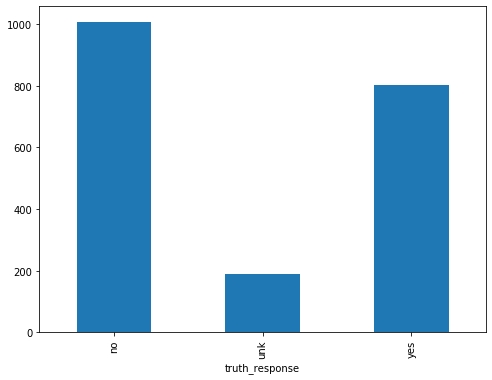

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,6))
df_train.groupby('truth_response').premise.count().plot.bar(ylim = 0)

plt.show()

In [7]:
df_train["category_id"].value_counts()

1    1008
0     803
2     189
Name: category_id, dtype: int64

Text Representation 

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

We will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf.

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df =5, ngram_range = (1, 3), strip_accents = 'unicode',
                            lowercase = True, stop_words = 'english', 
                             tokenizer = word_tokenize)


features = vectorizer.fit_transform(df_train.premise).toarray()

labels = df_train.category_id

features.shape

(2000, 835)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1,
                                                   random_state = 0)

Model Selection

Naive Bayes Classifier

In [13]:
from sklearn.naive_bayes import MultinomialNB

In [16]:
clf = MultinomialNB().fit(X_train, y_train)
y_nb_predicted = clf.predict(X_test)

print(y_nb_predicted)

[1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1
 0 1 0 1 0 0 1 1 0 1 0 2 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 1 1 1
 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 1 1
 1 1 1 1 0 0 1 0 0 1 0 1 1 1 1]


In [17]:
print(' \n confusion_matrix \n ')

 
 confusion_matrix 
 


In [20]:
cm = confusion_matrix(y_test, y_nb_predicted)
print(cm)

[[39 45  0]
 [28 68  1]
 [ 3 16  0]]


In [21]:
print('\n Here is the classification report:')


 Here is the classification report:


In [23]:
print(classification_report(y_test, y_nb_predicted))

              precision    recall  f1-score   support

           0       0.56      0.46      0.51        84
           1       0.53      0.70      0.60        97
           2       0.00      0.00      0.00        19

    accuracy                           0.54       200
   macro avg       0.36      0.39      0.37       200
weighted avg       0.49      0.54      0.50       200



Decision trees

In [24]:
from sklearn import tree

In [28]:
clf = tree.DecisionTreeClassifier().fit(X_train, y_train)

In [30]:
y_tree_predicted = clf.predict(X_test)
print(y_tree_predicted)

[2 1 1 1 1 0 1 1 0 2 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 0 1 2 2
 2 1 1 1 1 0 0 0 1 2 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 2 1 1 0 1 1 0 1
 0 1 0 0 1 1 1 0 0 2 0 2 1 2 1 0 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0
 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 2 1 0 1 1 1 1 0 1 0 1
 0 1 1 1 1 0 1 1 1 0 2 0 1 0 2 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 2 0 1 0
 1 1 2 0 2 0 0 1 1 1 0 1 1 1 0]


In [31]:
print (' \n Here is the classification report:')

 
 Here is the classification report:


In [32]:
print(classification_report(y_test, y_tree_predicted))

              precision    recall  f1-score   support

           0       0.49      0.48      0.48        84
           1       0.52      0.56      0.54        97
           2       0.12      0.11      0.11        19

    accuracy                           0.48       200
   macro avg       0.38      0.38      0.38       200
weighted avg       0.47      0.48      0.48       200



The Random forest algorithm

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
model = RandomForestClassifier(n_estimators=10)
RF_clf = model.fit(X_train, y_train)
predicted = RF_clf.predict(X_test)

In [70]:
cm = confusion_matrix(y_test, predicted)
print(cm)

[[38 43  3]
 [32 58  7]
 [ 7 11  1]]


In [42]:
print('\n Here is the classification report:')


 Here is the classification report:


In [43]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.49      0.45      0.47        84
           1       0.52      0.60      0.56        97
           2       0.09      0.05      0.07        19

    accuracy                           0.48       200
   macro avg       0.37      0.37      0.36       200
weighted avg       0.47      0.48      0.47       200

